## Imports e configurações

In [38]:
import pandas as pd
from kaggle.api.kaggle_api_extended import KaggleApi
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import pickle
from pycaret.classification import setup, compare_models, save_model, get_config
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score, f1_score
import os

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

## Obtenção e tratamento inicial dos dados

In [39]:
data_path = '../data/raw/'
kaggle_api = KaggleApi()
kaggle_api.authenticate()
kaggle_api.dataset_download_files("jseebs/disaster-dataset", path=data_path, unzip=True)

Dataset URL: https://www.kaggle.com/datasets/jseebs/disaster-dataset


In [40]:
df = pd.read_csv(f"{data_path}/public_emdat_project.csv", encoding='latin1')
print(df.shape)
df.head()

(15784, 46)


,DisNo.,Historic,Classification Key,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,External IDs,Event Name,ISO,Country,Subregion,Region,Location,Origin,Associated Types,OFDA/BHA Response,Appeal,Declaration,AID Contribution ('000 US$),Magnitude,Magnitude Scale,Latitude,Longitude,River Basin,Start Year,Start Month,Start Day,End Year,End Month,End Day,Total Deaths,No. Injured,No. Affected,No. Homeless,Total Affected,Reconstruction Costs ('000 US$),"Reconstruction Costs, Adjusted ('000 US$)",Insured Damage ('000 US$),"Insured Damage, Adjusted ('000 US$)",Total Damage ('000 US$),"Total Damage, Adjusted ('000 US$)",CPI,Admin Units,Entry Date,Last Update
0,1999-9388-DJI,No,nat-cli-dro-dro,Natural,Climatological,Drought,Drought,NaN,NaN,DJI,Djibouti,Sub-Saharan Africa,Africa,"Ali Sabieh, Dikhil, Djibouti, Obock, Tadjourah...",NaN,NaN,Yes,No,No,1556.0,NaN,Km2,NaN,NaN,NaN,2001,6.0,NaN,2001,NaN,NaN,NaN,NaN,100000.0,NaN,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,58.111474,"[{""adm1_code"":1093,""adm1_name"":""Ali Sabieh""},{...",2006-03-01,2023-09-25
1,1999-9388-SDN,No,nat-cli-dro-dro,Natural,Climatological,Drought,Drought,NaN,NaN,SDN,Sudan,Northern Africa,Africa,"Northern Darfur, Northern Kordofan, Red Sea pr...",NaN,Food shortage|Water shortage,No,No,No,NaN,NaN,Km2,NaN,NaN,NaN,2000,1.0,NaN,2001,NaN,NaN,NaN,NaN,2000000.0,NaN,2000000.0,NaN,NaN,NaN,NaN,NaN,NaN,56.514291,"[{""adm1_code"":2757,""adm1_name"":""Northern Darfu...",2006-03-08,2023-09-25
2,1999-9388-SOM,No,nat-cli-dro-dro,Natural,Climatological,Drought,Drought,NaN,NaN,SOM,Somalia,Sub-Saharan Africa,Africa,"Ceel Barde, Rab Dhuure, Tayeeglow, Xudur distr...",NaN,Food shortage,No,No,No,NaN,NaN,Km2,NaN,NaN,NaN,2000,1.0,NaN,2001,NaN,NaN,21.0,NaN,1200000.0,NaN,1200000.0,NaN,NaN,NaN,NaN,NaN,NaN,56.514291,"[{""adm1_code"":2691,""adm1_name"":""Bay""},{""adm1_c...",2006-03-08,2023-09-25
3,2000-0001-AGO,No,tec-tra-roa-roa,Technological,Transport,Road,Road,NaN,NaN,AGO,Angola,Sub-Saharan Africa,Africa,Calulo,NaN,NaN,No,No,No,NaN,NaN,NaN,NaN,NaN,NaN,2000,1.0,26.0,2000,1.0,26.0,14.0,11.0,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,56.514291,NaN,2004-10-27,2023-09-25
4,2000-0002-AGO,No,nat-hyd-flo-riv,Natural,Hydrological,Flood,Riverine flood,NaN,NaN,AGO,Angola,Sub-Saharan Africa,Africa,"Dombre Grande village (Baia Farta district, Be...",Heavy rain,NaN,No,No,Yes,NaN,47000.0,Km2,NaN,NaN,"Coporolo, Kwanza, Lucala",2000,1.0,8.0,2000,1.0,15.0,31.0,NaN,70000.0,NaN,70000.0,NaN,NaN,NaN,NaN,10000.0,17695.0,56.514291,"[{""adm2_code"":4214,""adm2_name"":""Baia Farta""},{...",2005-02-03,2023-09-25


De acordo com os metadados (disponíveis em https://doc.emdat.be/docs/data-structure-and-content/emdat-public-table/), podemos inferir que algumas colunas são descartáveis.

Vamos verificar a quantidade de nulos em cada coluna

In [41]:
print(df.isnull().sum())

DisNo.                                           0
Historic                                         0
Classification Key                               0
Disaster Group                                   0
Disaster Subgroup                                0
Disaster Type                                    0
Disaster Subtype                                 0
External IDs                                 13379
Event Name                                   10829
ISO                                              0
Country                                          0
Subregion                                        0
Region                                           0
Location                                       648
Origin                                       11829
Associated Types                             12488
OFDA/BHA Response                                0
Appeal                                           0
Declaration                                      0
AID Contribution ('000 US$)    

Dada a descrição de Historic ("Binary field specifying whether or not the disaster happened before 2000, using the Start Year. Data before 2000 should be considered of lesser quality (see Time Bias)"), cabe verificar se a coluna é útil ou não para filtragem do dataset.


In [42]:
print(df['Historic'].value_counts())

Historic
No    15784
Name: count, dtype: int64


Não é o caso. Vamos dropá-lo com as várias colunas que não serão necessárias, ou que vazarão dados

In [43]:
df = df.drop(columns=['Historic',
                      'DisNo.',
                      'Classification Key',
                      'External IDs',
                      'Event Name',
                      'ISO',
                      'CPI',
                      'Entry Date',
                      'Last Update',

                      'Location', #Variável categórica demasiado granular
                      
                      #Muitos nulos
                      'Origin',
                      'Associated Types',
                      'Latitude', #Além de muitos nulos, a informação já está implícita em outras variáveis
                      'Longitude', #Idem
                      'River Basin',

                      #Avaliamos como sem impacto
                      'Start Year',
                      'Start Day',

                      #Obteríamos as seguintes variáveis somente no término do evento, sendo inútil para prever o impacto do desastre no seu início
                      'End Year',
                      'End Month',
                      'End Day',
                      "Insured Damage ('000 US$)",
                      "Reconstruction Costs, Adjusted ('000 US$)",
                      "Reconstruction Costs ('000 US$)",
                      "Insured Damage, Adjusted ('000 US$)",
                      "Total Damage ('000 US$)",                      
                      "Total Damage, Adjusted ('000 US$)",
                      "AID Contribution ('000 US$)",
                      "Admin Units",
                            

                      #Além do motivo acima, 'Total Affected' já entrega as três abaixo combinadas
                      'No. Injured',
                      'No. Affected',
                      'No. Homeless',
                      ])

print(df.columns)

Index(['Disaster Group', 'Disaster Subgroup', 'Disaster Type',
       'Disaster Subtype', 'Country', 'Subregion', 'Region',
       'OFDA/BHA Response', 'Appeal', 'Declaration', 'Magnitude',
       'Magnitude Scale', 'Start Month', 'Total Deaths', 'Total Affected'],
      dtype='object')


In [44]:
print(df.isnull().sum())

Disaster Group           0
Disaster Subgroup        0
Disaster Type            0
Disaster Subtype         0
Country                  0
Subregion                0
Region                   0
OFDA/BHA Response        0
Appeal                   0
Declaration              0
Magnitude            12406
Magnitude Scale       5892
Start Month             69
Total Deaths          3129
Total Affected        4102
dtype: int64


## EDA

Dado que já fizemos uma limpeza preliminar, cabe agora analisar estatisticasmente o dataset para concluir sua preparação para o treino.

Faz parte dessa tarefa a seleção da métrica-alvo mais adequada ao nosso objetivo.



Variáveis que por ora são boas candidatas para serem métricas-alvo, dado nosso objetivo de criar um modelo que ajude com a predição de riscos:

In [45]:
categorical_potential_target = [
#Lembrando que se uma das três abaixo fossem como preditoras, provavelmente vazariam dados sobre as demais
                    'OFDA/BHA Response',
                    'Appeal',
                    'Declaration',
                    ]

numerical_potential_target = [
                    'Total Affected',
                    'Total Deaths',
                    ]

In [46]:
for col in categorical_potential_target:
    print(df[col].value_counts())

OFDA/BHA Response
No     15108
Yes      676
Name: count, dtype: int64
Appeal
No     15611
Yes      173
Name: count, dtype: int64
Declaration
No     14739
Yes     1045
Name: count, dtype: int64


Dado o grande desbalanceamento dessas classes, além do fato de não estarem diretamente relacionadas ao nível de risco de um desastre, vamos desconsiderar seu uso como targets.

Igualmente, elas não consistem em dados que obteríamos no momento da tragédia, então não faz sentido usá-las sequer como preditoras no nosso contexto.

Vamos, pois, entender a usabilidade das numéricas selecionadas como target.

In [47]:
df = df.drop(columns=categorical_potential_target)
print(df.columns)

Index(['Disaster Group', 'Disaster Subgroup', 'Disaster Type',
       'Disaster Subtype', 'Country', 'Subregion', 'Region', 'Magnitude',
       'Magnitude Scale', 'Start Month', 'Total Deaths', 'Total Affected'],
      dtype='object')


In [48]:
for col in numerical_potential_target:
    print(df[col].describe())


count    1.168200e+04
mean     3.955015e+05
std      5.334026e+06
min      1.000000e+00
25%      4.000000e+01
50%      9.570000e+02
75%      1.668700e+04
max      3.300000e+08
Name: Total Affected, dtype: float64
count     12655.000000
mean        135.976847
std        3088.333299
min           0.000000
25%           9.000000
50%          16.000000
75%          32.000000
max      222570.000000
Name: Total Deaths, dtype: float64


Parecem ambas utilizáveis, e consideramos criar um sistema que preveja o risco tanto em termo de pessoas afetadas quanto mortas.

Nada obstante, não nos parece razoável tratar esse problema com uma regressão, posto que tanto não possuimos um número suficientemente grande de variáveis preditoras numéricas para trazer precisão às nossas predições quanto o risco de um desastre não precisa ser medido em números exatos. É mais conveniente, inclusive, utilizar marcações de intensidade para esses fatores para definir os níveis de risco e por isso estudaremos a melhor maneira de utilizar essas variáveis em um problema de classificação.

Primeiramente, cientes de que ambas as potenciais target possuem um número de nulls alto, cabe estudar o quanto elas se interseccionam em null para avaliar se é o caso de dropar todas as linhas nulls, ou se devemos fazer isso apenas posteriormente, no momento dos treinamentos dos classificadores em separado.

In [49]:
total_affected_nulls= df['Total Affected'].isna()
total_deaths_nulls = df['Total Deaths'].isna()
intersecao_nulls = total_affected_nulls & total_deaths_nulls
print(f"Total Affected nulls: {total_affected_nulls.sum()}")
print(f"Total Deaths nulls: {total_deaths_nulls.sum()}")    
print(f"Intersection of nulls: {intersecao_nulls.sum()}")


Total Affected nulls: 4102
Total Deaths nulls: 3129
Intersection of nulls: 600


Dado que a interseção é pequena, cabe seguir com a limpeza dos dados para tomar uma decisão final sobre como proceder com os nulls.

E dois caminhos significativos são abordagens analíticas sobre nossas principais variáveis preditoras, 1) as relacionadas ao tipo de desastre e 2) as relacionadas à região do desastre, grupos que deverão ser resumidos cada qual a um único para evitar repetição de informação inútil.


In [50]:
disaster_variables = ['Disaster Group', 'Disaster Subgroup', 'Disaster Type', 'Disaster Subtype']

region_variables = ['Region', 'Subregion', 'Country']

Comecemos com a análise das variáveis relacionadas ao tipo de desastre, destrinchando-as do grupo maior ao último subgrupo.

Primeiro é necessário verificar se há interseção do grupo maior até o último subgrupo, no sentido por exemplo de um disaster type poder pertencer a mais de um disaster subgroup. Isso impactaria nossa possibilidade de resumir os quatro grupos em um só.

In [51]:
hierarchy = [
    ('Disaster Group', 'Disaster Subgroup'),
    ('Disaster Subgroup', 'Disaster Type'),
    ('Disaster Type', 'Disaster Subtype')
]

for higher, lower in hierarchy:
    relation = df.groupby(lower)[higher].nunique()
    ambiguous = relation[relation > 1]

    print(f"\n{lower} associados a múltiplos {higher}:")
    if ambiguous.empty:
        print(f"✅ Todos os valores de '{lower}' pertencem a apenas um '{higher}'.")
    else:
        print(f"⚠️ {len(ambiguous)} casos encontrados onde '{lower}' está ligado a mais de um '{higher}'.")
        print(ambiguous)



Disaster Subgroup associados a múltiplos Disaster Group:
✅ Todos os valores de 'Disaster Subgroup' pertencem a apenas um 'Disaster Group'.

Disaster Type associados a múltiplos Disaster Subgroup:
✅ Todos os valores de 'Disaster Type' pertencem a apenas um 'Disaster Subgroup'.

Disaster Subtype associados a múltiplos Disaster Type:
✅ Todos os valores de 'Disaster Subtype' pertencem a apenas um 'Disaster Type'.


Dado que os dados respeitam uma hierarquia (o que já podemos aliás supor valer de igual para region_variables, por óbvio), podemos avaliar se há classes granulares que desejamos descartar do nosso treino para evitar ruído.

In [52]:
for col in disaster_variables:
    print(df[col].value_counts())

Disaster Group
Natural          10045
Technological     5739
Name: count, dtype: int64
Disaster Subgroup
Hydrological              4531
Transport                 3912
Meteorological            3067
Miscellaneous accident     924
Biological                 924
Industrial accident        903
Geophysical                804
Climatological             718
Extra-terrestrial            1
Name: count, dtype: int64
Disaster Type
Flood                               4070
Storm                               2575
Road                                2124
Water                               1111
Epidemic                             894
Earthquake                           665
Extreme temperature                  492
Mass movement (wet)                  461
Explosion (Industrial)               458
Air                                  430
Fire (Miscellaneous)                 421
Drought                              408
Wildfire                             306
Rail                                 247
Mi

Já de início podemos desconsiderar o elemento Disaster Group, após filtrá-lo por = Natural, dado que nosso projeto foca em desastres naturais.

In [53]:
df = df[df['Disaster Group'] == 'Natural']
df = df.drop(columns=['Disaster Group'])
disaster_variables.remove('Disaster Group')

#Analisando novamente
for col in disaster_variables:
    print(df[col].value_counts())

Disaster Subgroup
Hydrological         4531
Meteorological       3067
Biological            924
Geophysical           804
Climatological        718
Extra-terrestrial       1
Name: count, dtype: int64
Disaster Type
Flood                          4070
Storm                          2575
Epidemic                        894
Earthquake                      665
Extreme temperature             492
Mass movement (wet)             461
Drought                         408
Wildfire                        306
Volcanic activity               126
Infestation                      29
Mass movement (dry)              13
Glacial lake outburst flood       4
Impact                            1
Animal incident                   1
Name: count, dtype: int64
Disaster Subtype
Riverine flood                      2024
Flood (General)                     1303
Tropical cyclone                    1301
Flash flood                          702
Ground movement                      635
Bacterial disease                 

Também podemos analisar mais visualmente:

In [54]:

def plot_suburst(columns_list,df=df):
    df_clean = df.dropna(subset=columns_list)
    fig = px.sunburst(
        df_clean,
        path=columns_list,
        title=f'Hierarquia de {columns_list}',
        maxdepth=-1 
    )
    fig.update_traces(insidetextorientation='radial')
    fig.show()

plot_suburst(disaster_variables)

Aplicaremos o critério de cada grupo ter no mínimo 100 ocorrências.

In [55]:
min_count = 100

# Itera por cada coluna e filtra o DataFrame
for col in disaster_variables:
    print(f"\nProcessando coluna: {col}")
    value_counts = df[col].value_counts()
    valid_values = value_counts[value_counts >= min_count].index.tolist()
    print(f"Valores mantidos em '{col}': {valid_values}")
    
    # Filtra o DataFrame com base nos valores válidos
    df = df[df[col].isin(valid_values)]

# Resultado final
print(f"\nNúmero de linhas no DataFrame final: {len(df)}")



Processando coluna: Disaster Subgroup
Valores mantidos em 'Disaster Subgroup': ['Hydrological', 'Meteorological', 'Biological', 'Geophysical', 'Climatological']

Processando coluna: Disaster Type
Valores mantidos em 'Disaster Type': ['Flood', 'Storm', 'Epidemic', 'Earthquake', 'Extreme temperature', 'Mass movement (wet)', 'Drought', 'Wildfire', 'Volcanic activity']

Processando coluna: Disaster Subtype
Valores mantidos em 'Disaster Subtype': ['Riverine flood', 'Flood (General)', 'Tropical cyclone', 'Flash flood', 'Ground movement', 'Bacterial disease', 'Drought', 'Viral disease', 'Landslide (wet)', 'Storm (General)', 'Cold wave', 'Severe weather', 'Forest fire', 'Heat wave', 'Blizzard/Winter storm', 'Lightning/Thunderstorms', 'Tornado', 'Extra-tropical storm', 'Ash fall']

Número de linhas no DataFrame final: 9437


In [56]:
plot_suburst(disaster_variables,df)

Podemos agopra trabalhar a nível de Disaster Subtype.

In [57]:
df = df.drop(columns=['Disaster Subgroup','Disaster Type'])

E podemos fazer uma análise parecida com relação às variáveis regionais.

In [58]:
plot_suburst(region_variables,df)

Dada a alta granularidade em Country, podemos trabalhar a nível de Subregion, excluindo Region e aquele.

In [59]:
df = df.drop(columns=['Region','Country'])

Vamos ver como está por ora nosso dataset analisando-o segundo a quantidade de nulls por variável

In [60]:
print(df.isnull().sum())
print(df.shape)

Disaster Subtype       0
Subregion              0
Magnitude           6192
Magnitude Scale      885
Start Month           65
Total Deaths        2708
Total Affected      1792
dtype: int64
(9437, 7)


Vamos analisar se 'Magnitude' está associada a Disaster Subtypes em especifico para usá-la em alguma engenharia de feature caso venha ao caso.

In [61]:
stats = df.groupby('Disaster Subtype')['Magnitude'].describe()
total_counts = df['Disaster Subtype'].value_counts()

# Contagem de não nulos por Disaster Subtype (já está no 'count' da estatística descritiva)
non_null_counts = stats['count']

# Cálculo dos nulos por subtração
count_nulls = total_counts - non_null_counts
stats['count_nulls'] = count_nulls

stats

,count,mean,std,min,25%,50%,75%,max,count_nulls
Disaster Subtype,,,,,,,,,
Ash fall,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102.0
Bacterial disease,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,421.0
Blizzard/Winter storm,19.0,89.684211,6.403476e+01,0.0,32.000,110.0,120.000,230.00,164.0
Cold wave,114.0,-16.817544,1.603001e+01,-57.0,-30.000,-19.0,0.000,10.00,111.0
Drought,27.0,52981.666667,1.447961e+05,0.0,554.500,1720.0,15100.000,560000.00,381.0
Extra-tropical storm,51.0,152.058824,3.190449e+01,80.0,130.000,150.0,173.000,220.00,93.0
Flash flood,251.0,70159.581036,1.892695e+05,0.0,3429.500,15490.0,65475.805,2440002.48,451.0
Flood (General),193.0,116425.372953,1.889938e+05,0.0,13364.220,50430.4,144300.000,1834048.30,1110.0
Forest fire,79.0,10298.867089,7.644385e+04,0.0,114.000,400.0,1161.500,680000.00,115.0


Infelizmente a variável está muito distribuída entre as classes de desastre, as quais igualmente contém muitos nulos para essa variável mesmo nos casos em que ela é melhor representada.

Temos de decidir por descartar mais essa variável da nossa análise

In [62]:
df = df.drop(columns=['Magnitude', 'Magnitude Scale'])

In [63]:
print(df.isnull().sum())

Disaster Subtype       0
Subregion              0
Start Month           65
Total Deaths        2708
Total Affected      1792
dtype: int64


In [64]:
#Dado que são poucas linhas, podemos descartar os nulos de Start Month
df = df.dropna(subset=['Start Month'])

Cumpre enfim segmentar as classes que vamos prever nas nossas colunas target, dado que visamos abordar problemas de classificação.

Cabe para tanto visualizar a distribuição de cada qual.

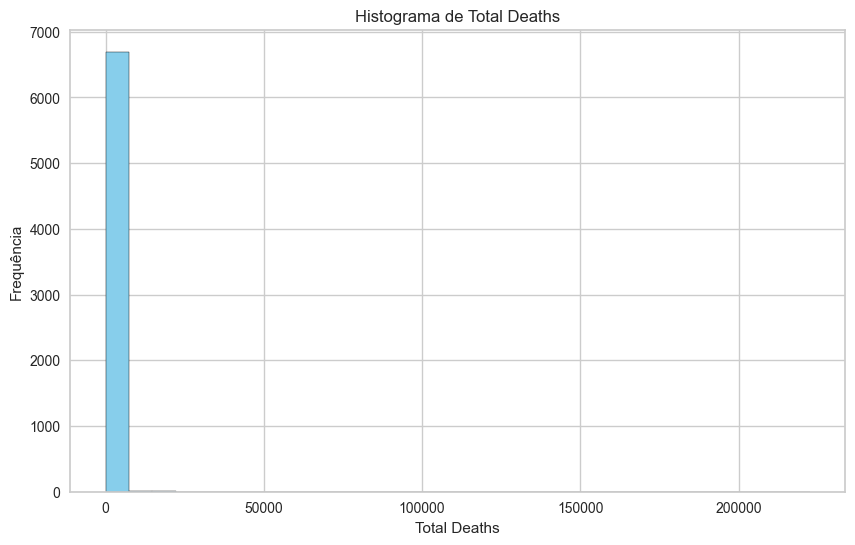

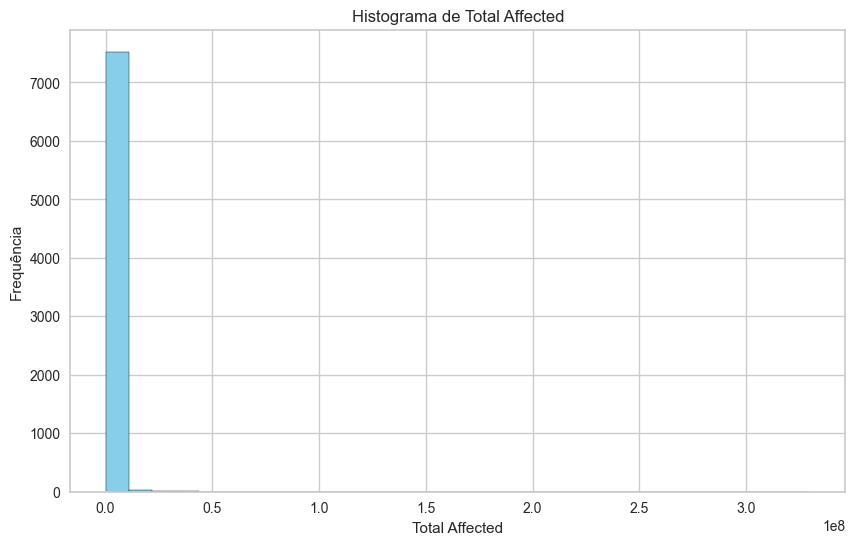

In [65]:

def plot_histogram(df, col, bins=30, title=None):
    """
    Plota um histograma da coluna especificada de um DataFrame.

    Parâmetros:
        df (pd.DataFrame): O DataFrame com os dados.
        col (str): Nome da coluna numérica para o histograma.
        bins (int): Número de bins (opcional, padrão: 30).
        title (str): Título do gráfico (opcional).
    """
    if col not in df.columns:
        print(f"Coluna '{col}' não encontrada no DataFrame.")
        return

    if not pd.api.types.is_numeric_dtype(df[col]):
        print(f"Coluna '{col}' não é numérica.")
        return

    plt.figure(figsize=(10, 6))
    plt.hist(df[col].dropna(), bins=bins, color='skyblue', edgecolor='black')
    plt.xlabel(col)
    plt.ylabel('Frequência')
    plt.title(title if title else f'Histograma de {col}')
    plt.grid(True)
    plt.show()

plot_histogram(df, 'Total Deaths')
plot_histogram(df, 'Total Affected')


Dado que a distribuição dessas variáveis é altamente concentrada, vamos ter que dividir ambas as categorias em um número mínimo de classes.

Com a seguinte abordagem, decidiremos se vamos dividir em 2 classes cada (dois problemas de classificação binária), ou mais, observando para tanto como ficaria uma divisão em três quartis.

In [66]:
def create_quantile_bins(df, col, q=8):
    """
    Cria uma nova coluna no DataFrame com binagem por quantis,
    desconsiderando nulos durante a criação, mas preenchendo a coluna toda.
    """
    bin_col = f"{col}_quantile_bin"

    # Aplicar qcut apenas nos valores não nulos
    mask = df[col].notna()
    bins = pd.qcut(df.loc[mask, col], q=q, duplicates='drop')

    # Inicializa a nova coluna com NaNs
    df[bin_col] = pd.NA

    # Preenche apenas os valores não nulos com os bins
    df.loc[mask, bin_col] = bins

    print(f"\n{col} – classes dos quantis (nulos desconsiderados):")
    print(df.loc[mask, bin_col].value_counts())

    return df



df_deathsQ2 = create_quantile_bins(df, 'Total Deaths', q=2)
df_deathsQ3 = create_quantile_bins(df, 'Total Deaths', q=3)
df_deathsQ4 = create_quantile_bins(df, 'Total Deaths', q=4)

df_affecteQ2 = create_quantile_bins(df, 'Total Affected', q=2)
df_affectedQ3 = create_quantile_bins(df, 'Total Affected', q=3)
df_affectedQ4 = create_quantile_bins(df, 'Total Affected', q=4)


Total Deaths – classes dos quantis (nulos desconsiderados):
Total Deaths_quantile_bin
(-0.001, 12.0]      3459
(12.0, 222570.0]    3255
Name: count, dtype: int64

Total Deaths – classes dos quantis (nulos desconsiderados):
Total Deaths_quantile_bin
(-0.001, 6.0]       2364
(22.0, 222570.0]    2231
(6.0, 22.0]         2119
Name: count, dtype: int64

Total Deaths – classes dos quantis (nulos desconsiderados):
Total Deaths_quantile_bin
(-0.001, 4.0]       1869
(34.0, 222570.0]    1640
(12.0, 34.0]        1615
(4.0, 12.0]         1590
Name: count, dtype: int64

Total Affected – classes dos quantis (nulos desconsiderados):
Total Affected_quantile_bin
(5251.0, 330000000.0]    3793
(0.999, 5251.0]          3793
Name: count, dtype: int64

Total Affected – classes dos quantis (nulos desconsiderados):
Total Affected_quantile_bin
(21403.333, 330000000.0]    2529
(0.999, 1374.333]           2529
(1374.333, 21403.333]       2528
Name: count, dtype: int64

Total Affected – classes dos quantis (nulo

Dada a alta concentração das variáveis, a divisão em três classes gera cortes pouco discriminativos nas faixas inferiores. A divisão binária, por sua vez, garante separação mais clara entre baixos e altos valores, sendo, portanto, a estratégia mais adequada.

Abaixo estabelecemos nossa proposta de abordagem do problema em duas classificações binárias

In [67]:

df['DeathCountAbove10'] = np.where(df['Total Deaths'].isna(), np.nan,
                                           np.where(df['Total Deaths'] > 10, 1, 0))

df['AffectedCountAbove1000'] = np.where(df['Total Affected'].isna(), np.nan,
                                          np.where(df['Total Affected'] > 1000, 1, 0))


print(df['DeathCountAbove10'].value_counts(dropna=False))
print(df['AffectedCountAbove1000'].value_counts(dropna=False))


DeathCountAbove10
1.0    3607
0.0    3107
NaN    2658
Name: count, dtype: int64
AffectedCountAbove1000
1.0    5274
0.0    2312
NaN    1786
Name: count, dtype: int64


## Consolidação dos dados de treino e teste
Após dropar as variáveis que não mais utilizaremos, vamos ver o estado atual do nosso dataset

In [68]:

df = df.drop(columns=['Total Deaths', 'Total Affected','Total Deaths_quantile_bin', 'Total Affected_quantile_bin'])
df.head()

,Disaster Subtype,Subregion,Start Month,DeathCountAbove10,AffectedCountAbove1000
0,Drought,Sub-Saharan Africa,6.0,NaN,1.0
1,Drought,Northern Africa,1.0,NaN,1.0
2,Drought,Sub-Saharan Africa,1.0,1.0,1.0
4,Riverine flood,Sub-Saharan Africa,1.0,1.0,1.0
5,Cold wave,Southern Asia,1.0,1.0,NaN


Finalmente vamos aplicar o One-Hot-Encoding nas colunas objeto, e salvá-lo para uso no app, sem chamá-lo adiante no pycaret.

**Atenção**: ler comentário sobre alteração na célula abaixo.

In [69]:
df['Start Month'] = df['Start Month'].astype('int')
df['Start Month'] = df['Start Month'].astype('object')

# Estávamos com dúvida sobre o quanto a variável em questão afetaria o desempenho do modelo e rodamos portanto a linha de drop abaixo com o Run All do VSCode
# Confirmando nossa suspeita, a variável ligeiramente piora a performance do melhor modelo. Por isso, não a manteremos.
df = df.drop(columns=['Start Month'])

object_cols = df.select_dtypes(include='object').columns
object_cols

Index(['Disaster Subtype', 'Subregion'], dtype='object')

Este é um bom momento para extrairmos um dataset de treino para o app final.

In [70]:
sample = df.sample(500)
app_test = sample.drop(columns=['AffectedCountAbove1000', 'DeathCountAbove10'])
app_test.to_csv("../data/processed/app_test.csv", index=False)

#Vamos tambem salvar um json que será usado em uma etapa de desenvolvimento do app
import json
valores_distintos = {col: app_test[col].dropna().unique().tolist() for col in app_test.columns}
with open("../data/processed/distinct_values.json", "w", encoding="utf-8") as f:
    json.dump(valores_distintos, f, ensure_ascii=False, indent=4)


In [71]:
encoder = OneHotEncoder(drop='first', sparse_output=False)

df_encoded = encoder.fit_transform(df[object_cols])
df_encoded = pd.DataFrame(df_encoded, columns=encoder.get_feature_names_out(object_cols), index=df.index)
df_final = pd.concat([df.drop(columns=object_cols), df_encoded], axis=1)

with open('../models/one-hot-encoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)

processed_data_path = '../data/processed/'

df_final.to_csv(f"{processed_data_path}/df_final.csv")
print(df_final.columns)


Index(['DeathCountAbove10', 'AffectedCountAbove1000',
       'Disaster Subtype_Bacterial disease',
       'Disaster Subtype_Blizzard/Winter storm', 'Disaster Subtype_Cold wave',
       'Disaster Subtype_Drought', 'Disaster Subtype_Extra-tropical storm',
       'Disaster Subtype_Flash flood', 'Disaster Subtype_Flood (General)',
       'Disaster Subtype_Forest fire', 'Disaster Subtype_Ground movement',
       'Disaster Subtype_Heat wave', 'Disaster Subtype_Landslide (wet)',
       'Disaster Subtype_Lightning/Thunderstorms',
       'Disaster Subtype_Riverine flood', 'Disaster Subtype_Severe weather',
       'Disaster Subtype_Storm (General)', 'Disaster Subtype_Tornado',
       'Disaster Subtype_Tropical cyclone', 'Disaster Subtype_Viral disease',
       'Subregion_Central Asia', 'Subregion_Eastern Asia',
       'Subregion_Eastern Europe', 'Subregion_Latin America and the Caribbean',
       'Subregion_Melanesia', 'Subregion_Micronesia',
       'Subregion_Northern Africa', 'Subregion_Northe

Vamos por fim obter os dados de treino e teste.

In [72]:
# Targets e a outra variável que deve ser excluída
targets = {
    'DeathCountAbove10': 'AffectedCountAbove1000',
    'AffectedCountAbove1000': 'DeathCountAbove10'
}

for target, to_drop in targets.items():
    df_target = df_final.drop(columns=[to_drop]).dropna(subset=[target])
    print(f"\nDistribuição das classes para o target '{target}':")
    print(df_target[target].value_counts(normalize=True).round(4) * 100)
    train, test = train_test_split(df_target, test_size=0.2, random_state=42)
    base_name = target.lower()
    train.to_csv(f'{processed_data_path}train_{base_name}.csv', index=False)
    test.to_csv(f'{processed_data_path}test_{base_name}.csv', index=False)
    print(f"train_{base_name}.shape = {train.shape}")
    print(f"test_{base_name}.shape = {test.shape}")


Distribuição das classes para o target 'DeathCountAbove10':
DeathCountAbove10
1.0    53.72
0.0    46.28
Name: proportion, dtype: float64
train_deathcountabove10.shape = (5371, 35)
test_deathcountabove10.shape = (1343, 35)

Distribuição das classes para o target 'AffectedCountAbove1000':
AffectedCountAbove1000
1.0    69.52
0.0    30.48
Name: proportion, dtype: float64
train_affectedcountabove1000.shape = (6068, 35)
test_affectedcountabove1000.shape = (1518, 35)


## Modelagem

Para maior praticidade, faremos a etapa de treino com AutoML.

Mas a avaliação faremos por fora sobre os dados de teste que separamos anteriormente.

In [73]:

def avaliar_modelo_teste(modelo, df_test, target_col):
    """
    Avalia um modelo PyCaret nos dados de teste e retorna um dicionário com métricas.

    Parâmetros:
        modelo: modelo treinado (PyCaret)
        df_test: DataFrame com dados de teste (contendo a coluna target_col)
        target_col: string, nome da coluna alvo (binária)
        scaler: objeto scaler usado no treino, se aplicável (pode ser None)

    Retorna:
        dict com métricas: AUC, Accuracy, Recall, Precision, F1
    """
    df_test_sem_target = df_test.drop(columns=[target_col], errors='ignore').copy()
    y_true = df_test[target_col].values

    try:
        y_pred_labels = modelo.predict(df_test_sem_target)
    except Exception as e:
        print(f"Erro ao prever labels: {e}")
        y_pred_labels = np.zeros_like(y_true)

    try:
        if hasattr(modelo, 'predict_proba'):
            y_scores = modelo.predict_proba(df_test_sem_target)[:, 1]
        else:
            y_scores = y_pred_labels
    except Exception as e:
        print(f"Erro ao prever scores: {e}")
        y_scores = np.zeros_like(y_true)
    resultado = {
        'Test_AUC': roc_auc_score(y_true, y_scores) if len(np.unique(y_scores)) > 1 else 0,
        'Test_Accuracy': accuracy_score(y_true, y_pred_labels),
        'Test_Recall': recall_score(y_true, y_pred_labels),
        'Test_Precision': precision_score(y_true, y_pred_labels),
        'Test_F1': f1_score(y_true, y_pred_labels)
    }
    return resultado

In [74]:
avaliacoes_completas = [] 
targets
for target in ['DeathCountAbove10', 'AffectedCountAbove1000']:
    base_name = target.lower()
    train_path = f'{processed_data_path}train_{base_name}.csv'
    test_path = f'{processed_data_path}test_{base_name}.csv'
    
    print(f"\n\n=== TREINAMENTO E AVALIAÇÃO PARA O TARGET: '{target}' ===")
    
    df_train = pd.read_csv(train_path)
    clf_setup = setup(
        data=df_train,
        target=target,
        session_id=42,
        verbose=False,
        use_gpu=True,
        fix_imbalance = True
    )
    
    # Linha abaixo usada para debug no processo (argumento model.feature_names_in_ retornando a target)
    #print("###", get_config("X_train").columns)

    best_models = compare_models(n_select=10, sort="AUC")
    
    
    df_test = pd.read_csv(test_path)
    
    for modelo in best_models:
        resultados = avaliar_modelo_teste(
            modelo=modelo,
            df_test=df_test,
            target_col=target,
        )
        resultados['Target'] = target
        resultados['Model'] = str(modelo) 
        avaliacoes_completas.append(resultados)

df_avaliacoes = pd.DataFrame(avaliacoes_completas)
df_avaliacoes = df_avaliacoes.sort_values(
    by=['Target', 'Test_AUC'], ascending=[True, False]
).reset_index(drop=True)

print("\n##### RESULTADO FINAL DAS AVALIAÇÕES #####")
display(df_avaliacoes)



=== TREINAMENTO E AVALIAÇÃO PARA O TARGET: 'DeathCountAbove10' ===
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Intel(R) UHD Graphics 770, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[Light

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.6853,0.7507,0.6719,0.7263,0.6975,0.3706,0.3723,0.9050
gbc,Gradient Boosting Classifier,0.6720,0.7489,0.5973,0.7458,0.6621,0.3514,0.3601,0.1760
rf,Random Forest Classifier,0.6866,0.7414,0.6803,0.7241,0.7011,0.3724,0.3735,0.1980
lr,Logistic Regression,0.6723,0.7403,0.6591,0.7140,0.6852,0.3445,0.3460,0.0690
et,Extra Trees Classifier,0.6810,0.7393,0.6621,0.7250,0.6915,0.3628,0.3649,0.1680
ridge,Ridge Classifier,0.6717,0.7391,0.6591,0.7134,0.6849,0.3434,0.3448,0.0530
lda,Linear Discriminant Analysis,0.6712,0.7386,0.6581,0.7130,0.6842,0.3424,0.3438,0.0640
dt,Decision Tree Classifier,0.6805,0.7380,0.6621,0.7242,0.6911,0.3617,0.3637,0.0530
ada,Ada Boost Classifier,0.6717,0.7379,0.6567,0.7148,0.6842,0.3436,0.3453,0.1190
qda,Quadratic Discriminant Analysis,0.6270,0.7308,0.8747,0.6104,0.7176,0.2168,0.2498,0.0610




=== TREINAMENTO E AVALIAÇÃO PARA O TARGET: 'AffectedCountAbove1000' ===
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Intel(R) UHD Graphics 770, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7019,0.7339,0.7300,0.8198,0.7720,0.3453,0.3505,0.0560
ridge,Ridge Classifier,0.7033,0.7333,0.7351,0.8180,0.7741,0.3453,0.3498,0.0480
lda,Linear Discriminant Analysis,0.7036,0.7326,0.7344,0.8188,0.7741,0.3465,0.3511,0.0490
gbc,Gradient Boosting Classifier,0.7015,0.7311,0.7494,0.8059,0.7764,0.3288,0.3310,0.2170
svm,SVM - Linear Kernel,0.7106,0.7294,0.7566,0.8129,0.7835,0.3486,0.3510,0.0610
lightgbm,Light Gradient Boosting Machine,0.6835,0.7287,0.7022,0.8153,0.7541,0.3168,0.3242,0.7080
ada,Ada Boost Classifier,0.7050,0.7279,0.7423,0.8154,0.7768,0.3441,0.3479,0.1290
rf,Random Forest Classifier,0.6793,0.7124,0.7151,0.8008,0.7551,0.2944,0.2988,0.1800
et,Extra Trees Classifier,0.6805,0.7091,0.7117,0.8046,0.7550,0.3004,0.3055,0.1620
dt,Decision Tree Classifier,0.6802,0.7074,0.7117,0.8043,0.7548,0.2997,0.3048,0.0460



##### RESULTADO FINAL DAS AVALIAÇÕES #####


,Test_AUC,Test_Accuracy,Test_Recall,Test_Precision,Test_F1,Target,Model
0,0.768133,0.723979,0.746269,0.844773,0.792472,AffectedCountAbove1000,LinearDiscriminantAnalysis(covariance_estimato...
1,0.763881,0.722003,0.741604,0.845745,0.790258,AffectedCountAbove1000,"LogisticRegression(C=1.0, class_weight=None, d..."
2,0.763761,0.730567,0.766791,0.837920,0.800779,AffectedCountAbove1000,"GradientBoostingClassifier(ccp_alpha=0.0, crit..."
3,0.756542,0.715415,0.736007,0.841151,0.785075,AffectedCountAbove1000,"AdaBoostClassifier(algorithm='SAMME.R', estima..."
4,0.755733,0.715415,0.733209,0.843348,0.784431,AffectedCountAbove1000,"LGBMClassifier(boosting_type='gbdt', class_wei..."
5,0.743055,0.718050,0.750933,0.833333,0.789990,AffectedCountAbove1000,"RandomForestClassifier(bootstrap=True, ccp_alp..."
6,0.739723,0.701581,0.706157,0.845810,0.769700,AffectedCountAbove1000,"ExtraTreesClassifier(bootstrap=False, ccp_alph..."
7,0.739319,0.698946,0.701493,0.845894,0.766956,AffectedCountAbove1000,"DecisionTreeClassifier(ccp_alpha=0.0, class_we..."
8,0.707403,0.722661,0.744403,0.844444,0.791274,AffectedCountAbove1000,"RidgeClassifier(alpha=1.0, class_weight=None, ..."
9,0.707108,0.730567,0.763993,0.840000,0.800195,AffectedCountAbove1000,"SGDClassifier(alpha=0.0001, average=False, cla..."


## Conclusão

Pretendíamos fazer uso de dois classificadores sobre os dados de entrada na nossa aplicação de modo a retornar mais informações, porém, ao avaliarmos as métricas das predições em teste para DeathCountAbove10, apesar de termos um valor próximo do aceitável em AUC, notamos que a performance nas demais métricas é muito baixa, incluindo Precision, o que é inaceitável no nosso contexto.

Por esse motivo, tomamos a decisão de operar com apenas uma métrica-alvo, AffectedCountAbove1000, fazendo uso do modelo LinearDiscriminantAnalysis que melhor performou em AUC de teste. Além do AUC, o modelo teve bom equilíbrio nas demais métricas, principalmente Precision, que é essencial no nosso caso, onde não deveríamos levar a muitos falsos positivos. 


Com isso, seguimos apenas com AffectedCountAbove1000 e o modelo escolhido, com maior alinhamento ao propósito da aplicação.










In [75]:

output_path = '../models/'
nome_arquivo = 'selected_model'
caminho_completo = os.path.join(output_path, nome_arquivo)

df_avaliacoes = df_avaliacoes.sort_values(by='Test_AUC', ascending=False)
melhor_modelo_nome = df_avaliacoes.iloc[0]['Model']
print(f"Melhor modelo: {melhor_modelo_nome}")

melhor_modelo = None
for modelo in best_models:
    if str(modelo) == melhor_modelo_nome:
        melhor_modelo = modelo
        break

if melhor_modelo:
    save_model(melhor_modelo, caminho_completo)
    print(f"Modelo salvo com sucesso em: {caminho_completo}.pkl")

Melhor modelo: LinearDiscriminantAnalysis(covariance_estimator=None, n_components=None,
                           priors=None, shrinkage=None, solver='svd',
                           store_covariance=False, tol=0.0001)
Transformation Pipeline and Model Successfully Saved
Modelo salvo com sucesso em: ../models/selected_model.pkl


## Teste de predições com o modelo escolhido

In [76]:
import sys
import os

sys.path.append(os.path.abspath("../"))

from models.classifier import RiskClassifier

classifier = RiskClassifier()

# Online prediction
sample = {
    "Disaster Subtype": "Flood (General)",
    "Subregion": "Latin America and the Caribbean"
}
result = classifier.predict_online(sample)
print(result)

df = pd.read_csv("../data/processed/app_test.csv", encoding='latin1')
batch_result = classifier.predict_batch(df)
batch_result.head()


{'predicted_label': 1.0, 'probability_score': [0.386725277499961, 0.613274722500039]}


,Disaster Subtype,Subregion,predicted_label,probability_class_0,probability_class_1
0,Flood (General),Sub-Saharan Africa,1.0,0.394236,0.605764
1,Flood (General),South-eastern Asia,1.0,0.272926,0.727074
2,Riverine flood,South-eastern Asia,1.0,0.181813,0.818187
3,Riverine flood,Eastern Europe,0.0,0.506853,0.493147
4,Flash flood,Western Asia,0.0,0.635767,0.364233
